<a href="https://colab.research.google.com/github/jiayuanteng/Hands_on_ML2/blob/main/8_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curse of dimensionality
If you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1,000,000-dimensional hypercube? The average distance, believe it or not, will be about 408.25. 

High-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other.

This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.



# Approaches for dimensionality reduction
## Principal component analysis (PCA)
PCA identifies the axis that accouts for the largest amount of variance in the training set. It is reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projection. Another way to justify this choice is that it is the axis that minimizes the mean squared distance betweeen the original dataset and its projection onto that axis. 

1. The *first* principal component direction of the data is that along which the observations *vary the most*. The first principal component vector defines the line that is as close as possible to the data.
2. The *second* principal component is orthogonal to the first one, and accounts for the largest amount of remaining variance. 

Suppose there are m features and n training instances, the first principal component is
$Z_1 = [λ_1, λ_2, ⋯, λ_m] X$
where X is a zero-centered matrix (X is demeaned)

$ X = 
\begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,n}\\
\vdots  & \vdots  & \ddots & \vdots \\ 
x_{m,1} & x_{m,2} & \cdots & x_{m,n}
\end{pmatrix} 
$



In [70]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [71]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [72]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

# project down to d dimensions
W2 = Vt.T[:, :2]
X2D_using_svd = X_centered.dot(W2)

## Using Scikit-Learn
1. Code takes care of mean centering
2. *explained_variance_ratio_* reports the proportion of the dataset's variance that lies along each principal component. 
3. Choose the right number of dimensions by defining a sufficiently large portion of the variance explained by the number of dimensions

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [74]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [75]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [76]:
pca.explained_variance_ratio_

print("projecting to lower dimentions loses {:.2%} of variance".format(1 - pca.explained_variance_ratio_.sum()))

projecting to lower dimentions loses 1.12% of variance


In [77]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)


X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [78]:
# or run the following to use the right number of PCs
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

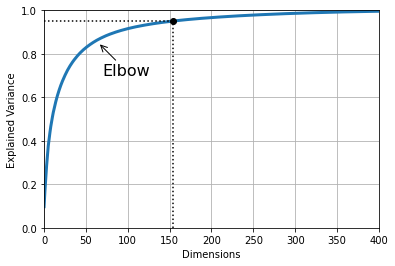

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

(-12.0, 15.0)

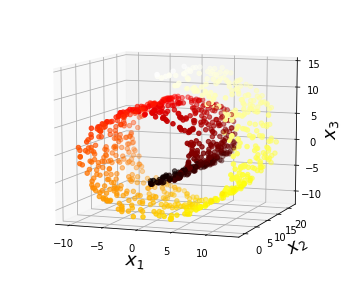

In [80]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize = (6,5))
ax = fig.add_subplot(111, projection = "3d")

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

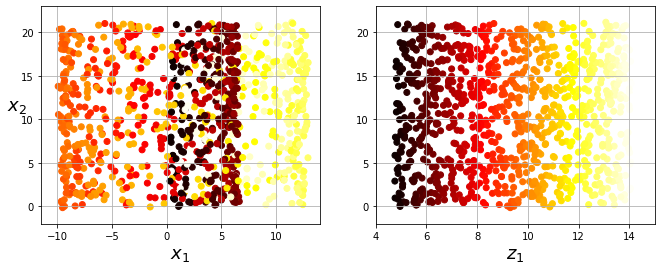

In [81]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

## PCA for compression
In the previous example, d = 154. This means that instead of the 784 features, the dataset is now less than 20% of its original size. 

One can decompress the reduced dataset back to 784 features by applying the inverse transformation of the PCA projection. This will not give back the original data, since the projection lost a bit of information (within the 5% variance that was dropped). The mean squared distance betweeen the original data and the reconstructed data (compressed and then decompressed) is called the **reconstruction error**





In [82]:
pca = PCA(n_components = d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

## Randomized PCA
One can set *svd_solver* to "randomized" to use *Randomized PCA* that quickly finds an approximation of the first *d* principal components. Its computational complexity is $O(m*d^2) + O(d^3)$, instead of $O(m*n^2) + O(n^3)$ for the full SVD approach. 

In [83]:
rnd_pca = PCA(n_components=d, svd_solver = "randomized")
X_reduced_rnd = rnd_pca.fit_transform(X_train)

In [84]:
X_reduced[:5, :5]

array([[-563.82559445,  376.21158528,  547.80926278, -181.1337753 ,
          79.09804891],
       [-247.60677316,  594.11581248, -761.17658857,   17.33651773,
         330.98071018],
       [ -76.10689476, -718.88626737, -621.34715826,   17.59080208,
        -210.32503067],
       [-633.72981425,  347.08707309, -262.40000713,   14.28145152,
         -16.79945558],
       [ 335.97493795,  962.59754213,  531.30152587, -219.19645165,
         298.07622031]])

In [85]:
X_reduced_rnd[:5, :5]

array([[-563.82559446,  376.21158521,  547.80926284, -181.13377517,
          79.09804846],
       [-247.60677316,  594.11581245, -761.17658854,   17.33651767,
         330.98071038],
       [ -76.10689475, -718.88626737, -621.34715835,   17.59080196,
        -210.32503041],
       [-633.72981424,  347.0870732 , -262.40000721,   14.28145137,
         -16.79945542],
       [ 335.97493798,  962.59754225,  531.30152576, -219.19645164,
         298.07622046]])

## Incremental PCA
*Incremental PCA (IPCA)* algorithms allows one to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.



In [86]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = d)

for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced_ipca = inc_pca.transform(X_train)

In [87]:
X_reduced_ipca[:5, :5]

array([[-563.82583139, -376.21181521, -547.8091286 ,  181.13344761,
          79.0983874 ],
       [-247.60624084, -594.11627098,  761.17702681,  -17.33736609,
         330.98145404],
       [ -76.10728626,  718.88715287,  621.34766956,  -17.59023347,
        -210.32277946],
       [-633.72976979, -347.08681704,  262.39992499,  -14.28223886,
         -16.79942497],
       [ 335.97482512, -962.59749386, -531.30164392,  219.19601046,
         298.07737363]])

In [89]:
filename = "my_mnist.data"
batch_size = 525

X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
#inc_pca.fit(X_mm)

## Kernel PCA
Basic idea of kernel PCA is to use a nonlinear kernel function *k* instead of the standard dot product. Kernel PCA implicitly perform PCA in a possibly high-dimensional space F which is nonlinearly related to input space. 

Finetuning hyperparameters can use following two ways. 
1. use grid search to select the kernel and hyperparameters that lead to the best performance on the task if downstream is a supervised task
2. minimize reconstruction error

In [90]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.4)
X_reduced = rbf_pca.fit_transform(X)

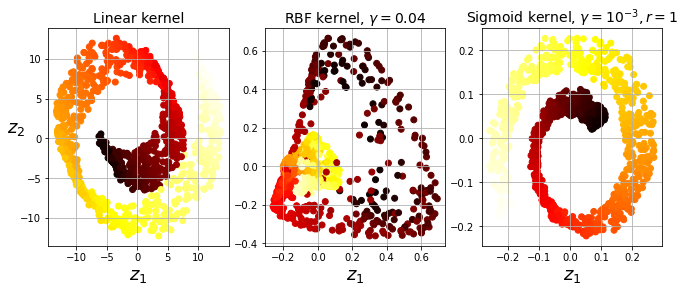

In [91]:
lin_pca = KernelPCA(n_components=2, kernel = "linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel = "rbf", gamma=0.0433,  fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel = "sigmoid", gamma=0.001,  fit_inverse_transform=True)

y = t>6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [93]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [94]:
from sklearn.metrics import mean_squared_error

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

32.786308795766125

In [95]:
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

param_grid = [{
        "gamma": np.linspace(0.03, 0.05, 10),
        "kernel": ["rbf", "sigmoid"]
    }]

kpca=KernelPCA(fit_inverse_transform=True, n_jobs=-1) 
grid_search = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(X)

GridSearchCV(cv=3, estimator=KernelPCA(fit_inverse_transform=True, n_jobs=-1),
             param_grid=[{'gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kernel': ['rbf', 'sigmoid']}],
             scoring=<function my_scorer at 0x7efc78e98170>)

In [96]:
print(grid_search.best_params_)

{'gamma': 0.034444444444444444, 'kernel': 'rbf'}


## Locally Linear Embedding (LLE)
It is a Manifold Learning technique that does not rely on projections, like the previous algorithms do. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved 

In [97]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [98]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

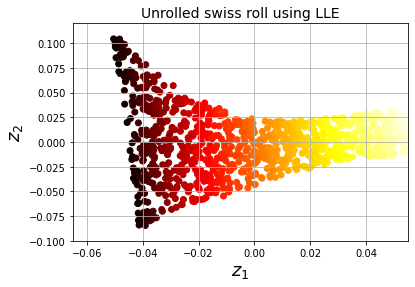

In [99]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)


## Other Dimensionality Reduction Technicques

In [100]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

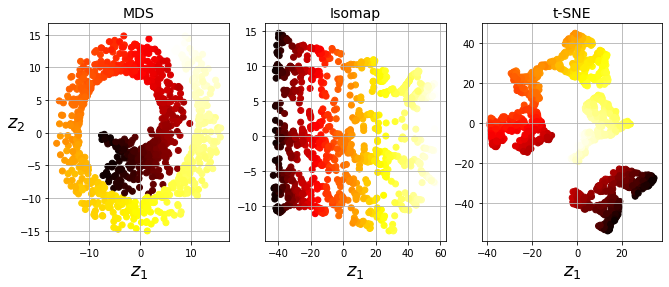

In [101]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
